In [1]:
from typing import List, Dict
import torch

import sys 
sys.path.append(".")
sys.path.append("..")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter
from utils import vis_utils
from utils.ptp_utils import AttentionStore

%load_ext autoreload 
%autoreload 2

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "e:\conda_data\envs\heavy_daily\lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'


# Load Model Weights (may take a few minutes)

In [2]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("g:code/model/stable-diffusion-v1-4",
                                                 torch_dtype=torch.float16).to(device)
tokenizer = stable.tokenizer

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# Pipeline Wrapper

In [3]:
# configurable parameters (see RunConfig for all parameters)
# scale factor- intensity of shift by gradient
# thresholds- a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0: 0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Show Cross-Attention Per Strengthened Token

## Define your seeds, prompt and the indices to strengthen

In [4]:
prompt = "an elephant with a crown"
seeds = [21]

In [5]:
token_indices = get_indices_to_alter(stable, prompt)

{1: 'an', 2: 'elephant', 3: 'with', 4: 'a', 5: 'crown'}
Altering tokens: ['elephant', 'crown']


## Stable Diffusion

c:\Users\Lenovo\Desktop\Paper-recover\Attend-and-Excite\Attend-and-Excite-main\notebooks\..\pipeline_attend_and_excite.py:486: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/50 [00:00<?, ?it/s]

e:\conda_data\envs\heavy_daily\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


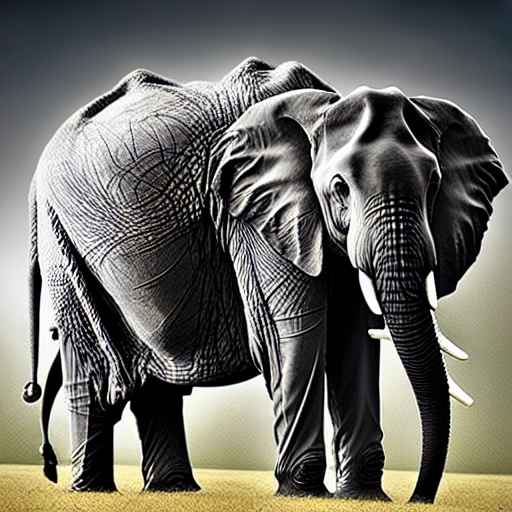

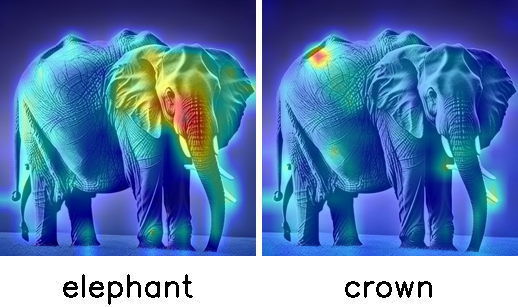

In [6]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            run_standard_sd=True,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)

## Attend-and-Excite

c:\Users\Lenovo\Desktop\Paper-recover\Attend-and-Excite\Attend-and-Excite-main\notebooks\..\pipeline_attend_and_excite.py:486: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8037
Iteration 1 | Loss: 0.0259
Iteration 2 | Loss: 0.0259
Iteration 3 | Loss: 0.0181
Iteration 4 | Loss: 0.0103
Iteration 5 | Loss: 0.0054
Iteration 6 | Loss: 0.0073
Iteration 7 | Loss: 0.0024
Iteration 8 | Loss: 0.0078
Iteration 9 | Loss: 0.0024
Iteration 10 | Loss: 0.0063
Iteration 11 | Loss: 0.0034
Iteration 12 | Loss: 0.0098
Iteration 13 | Loss: 0.0137
Iteration 14 | Loss: 0.0225
Iteration 15 | Loss: 0.0293
Iteration 16 | Loss: 0.0327
Iteration 17 | Loss: 0.0312
Iteration 18 | Loss: 0.0332
Iteration 19 | Loss: 0.0356
Iteration 20 | Loss: 0.0386
Iteration 21 | Loss: 0.0566
Iteration 22 | Loss: 0.0488
Iteration 23 | Loss: 0.0610
Iteration 24 | Loss: 0.0552


e:\conda_data\envs\heavy_daily\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


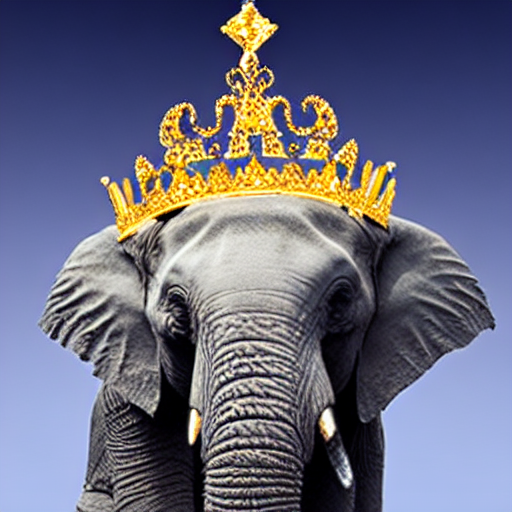

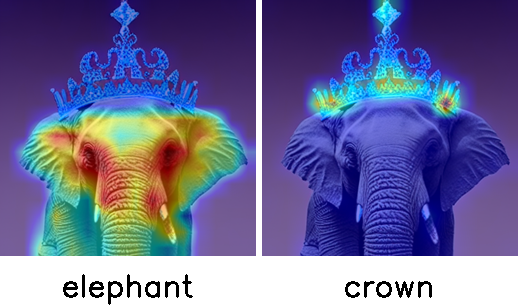

In [8]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            generator=g,
                            run_standard_sd=False,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)